# Customer Lifetime Value (CLV) Analysis

**Objective:**  
Estimate future customer value to inform marketing, retention, and strategic business decisions.

**Dataset:**  
Transaction-level data from Online Retail II (UK-based online retailer), including:
- `Invoice` — invoice number  
- `StockCode` — product identifier  
- `Description` — product description  
- `Quantity` — units purchased  
- `InvoiceDate` — date/time of purchase  
- `Price` — unit price  
- `Customer ID` — unique customer identifier  
- `Country` — country of purchase  

**Approach:**  
1. **Data Preprocessing and Cleaning**  
   - Remove duplicates, handle missing values, and ensure consistent data types.  

2. **Customer-Level Aggregation**  
   - Aggregate transactions per customer to compute RFM metrics:  
     - **Recency** — days since last purchase  
     - **Frequency** — total number of repeat purchases  
     - **Monetary Value** — average purchase value  

3. **CLV Modelling**  
   - **BG/NBD**: predict future purchase frequency  
   - **Gamma-Gamma**: estimate expected transaction value  
   - Compute **6-month CLV** and identify top customers  
   - Visualize distributions of predicted purchases and CLV  

4. **Insights and Recommendations**  
   - Analyze model outputs to identify high-value customers  
   - Provide actionable strategies for retention and revenue growth

## 1. Data Preprocessing and Cleaning
Remove duplicates, handle missing values, and ensure consistent data types.

In [4]:
# Imports & database path
import pandas as pd
import sqlite3
from pathlib import Path
from lifetimes import BetaGeoFitter, GammaGammaFitter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Database path
DB_PATH = Path(r"C:\Users\harri\OneDrive\Desktop\Work\Projects\clv_retention_optimization\data\retail.db")

# Connect and load transaction table
conn = sqlite3.connect(DB_PATH)
transactions = pd.read_sql("SELECT * FROM transactions", conn)

# Standardize InvoiceDate
transactions["InvoiceDate"] = pd.to_datetime(transactions["InvoiceDate"])

# Clean data: remove missing Customer ID, negative quantities or prices
transactions = transactions[
    transactions["Customer ID"].notnull() &
    (transactions["Quantity"] > 0) &
    (transactions["Price"] > 0)
]

# Ensure Customer ID is integer
transactions["Customer ID"] = transactions["Customer ID"].astype(int)

transactions.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom


## 2. Customer-Level Aggregation (RFM)

Aggregate transaction-level data into customer-level features:
- **Frequency:** Number of unique invoices per customer  
- **Recency:** Days between first and last purchase  
- **T:** Days from first purchase to dataset end  
- **Monetary Value:** Average spend per invoice

In [5]:
# Dataset end date
dataset_end = transactions["InvoiceDate"].max()

# RFM aggregation
rfm = transactions.groupby("Customer ID").agg(
    frequency=("Invoice", "nunique"),
    recency_days=("InvoiceDate", lambda x: (x.max() - x.min()).days),
    T_days=("InvoiceDate", lambda x: (dataset_end - x.min()).days),
    monetary_value=("Price", lambda x: (x * transactions.loc[x.index, "Quantity"]).sum() / x.nunique())
).reset_index()

# Remove any customers with non-positive monetary value
rfm = rfm[rfm["monetary_value"] > 0]

# Persist to database for reproducibility
rfm.to_sql("customer_rfm", conn, if_exists="replace", index=False)
conn.close()

rfm.head()

,Customer ID,frequency,recency_days,T_days,monetary_value
0,12346,12,400,725,12926.076667
1,12347,8,402,403,170.706667
2,12348,5,362,437,252.425000
3,12349,4,570,588,94.227447
4,12350,1,0,309,47.771429


## 3. CLV Modelling

- **BG/NBD model:** Predict future number of transactions  
- **Gamma-Gamma model:** Predict expected monetary value  
- Combine for **6-month CLV**

=== BG/NBD Model: Predicted Purchases (Next 30 Days) ===


,Customer ID,frequency,recency,T,predicted_purchases_30d
2538,14911,398,737,738,15.350407
400,12748,336,734,734,13.037504
5433,17841,211,735,736,8.179235
2935,15311,208,738,738,8.045543
739,13089,203,734,736,7.867338
2237,14606,192,735,736,7.446561
1789,14156,156,728,738,5.987486
2277,14646,151,735,736,5.865501
5692,18102,145,738,738,5.621469
1331,13694,143,731,734,5.566564


=== Gamma-Gamma Model: Expected Transaction Value ===


,Customer ID,monetary_value,expected_avg_value
4061,16446,56157.500000,48782.014209
2722,15098,19958.250000,18137.477486
0,12346,12926.076667,12610.490452
3382,15760,13916.340000,12100.164993
1663,14028,10396.500000,9453.160811
3390,15769,8870.432000,8813.127277
678,13027,8667.600000,8533.325959
569,12918,10953.500000,8432.772079
2277,14646,6146.540930,6134.460879
3371,15749,6362.042857,5788.925347


=== Top 10 Customers by 6-Month CLV ===


,Customer ID,CLV_6mo
2277,14646,204464.88
2538,14911,192555.88
5692,18102,107235.92
2685,15061,103914.81
1789,14156,96056.90
5540,17949,93465.71
4061,16446,93036.32
3390,15769,91632.95
1331,13694,82696.03
739,13089,71395.71


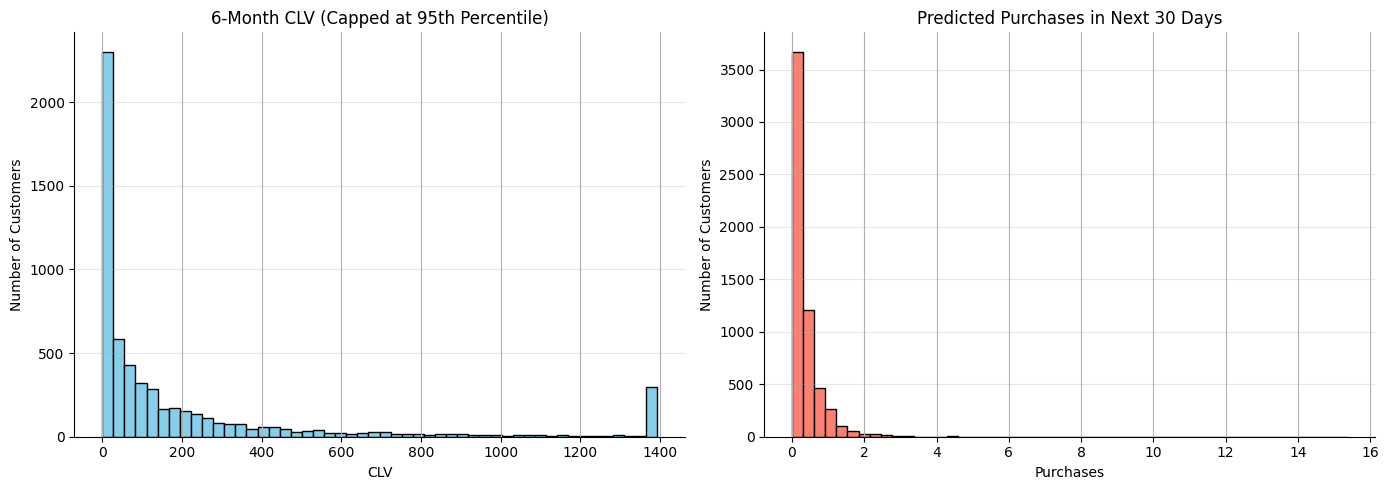

In [6]:
# ============================
# Customer Lifetime Value Analysis
# ============================

# Rename columns for lifetimes consistency
rfm = rfm.rename(columns={"recency_days": "recency", "T_days": "T"})

# 1 BG/NBD Model: Predict Purchase Frequency
# ----------------------------
from lifetimes import BetaGeoFitter
bgf = BetaGeoFitter(penalizer_coef=0)
bgf.fit(rfm["frequency"], rfm["recency"], rfm["T"])

# Predict purchases for next 30 days
rfm["predicted_purchases_30d"] = bgf.conditional_expected_number_of_purchases_up_to_time(
    30, rfm["frequency"], rfm["recency"], rfm["T"]
)

print("=== BG/NBD Model: Predicted Purchases (Next 30 Days) ===")
display(rfm[["Customer ID", "frequency", "recency", "T", "predicted_purchases_30d"]].sort_values(
    "predicted_purchases_30d", ascending=False
).head(10))

# 2️ Gamma-Gamma Model: Predict Transaction Value
# ----------------------------
from lifetimes import GammaGammaFitter
ggf = GammaGammaFitter(penalizer_coef=0)
ggf.fit(rfm["frequency"], rfm["monetary_value"])

# Expected average transaction value
rfm["expected_avg_value"] = ggf.conditional_expected_average_profit(
    rfm["frequency"], rfm["monetary_value"]
)

print("=== Gamma-Gamma Model: Expected Transaction Value ===")
display(rfm[["Customer ID", "monetary_value", "expected_avg_value"]].sort_values(
    "expected_avg_value", ascending=False
).head(10))


# 3️ Combined CLV: 6-Month Customer Lifetime Value
# ----------------------------
rfm["CLV_6mo"] = ggf.customer_lifetime_value(
    bgf, rfm["frequency"], rfm["recency"], rfm["T"], rfm["monetary_value"],
    time=6, freq="D", discount_rate=0.01
)

# Round numeric columns for readability
cols_to_round = ["recency", "T", "monetary_value", "predicted_purchases_30d", "expected_avg_value", "CLV_6mo"]
rfm[cols_to_round] = rfm[cols_to_round].round(2)

top_clv_customers = rfm[["Customer ID", "CLV_6mo"]].sort_values("CLV_6mo", ascending=False).head(10)
print("=== Top 10 Customers by 6-Month CLV ===")
display(top_clv_customers)


# 4️ Visualization: CLV & Predicted Purchases
# ----------------------------
import matplotlib.pyplot as plt
import numpy as np

clv_cap = np.percentile(rfm['CLV_6mo'], 95)  # Cap for skew

fig, axes = plt.subplots(1, 2, figsize=(14,5))

# CLV Distribution
rfm["CLV_6mo"].clip(upper=clv_cap).hist(
    bins=50, color='skyblue', edgecolor='black', ax=axes[0]
)
axes[0].set_title("6-Month CLV (Capped at 95th Percentile)", fontsize=12)
axes[0].set_xlabel("CLV", fontsize=10)
axes[0].set_ylabel("Number of Customers", fontsize=10)
axes[0].grid(axis='y', alpha=0.3)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# Predicted Purchases Distribution
rfm["predicted_purchases_30d"].hist(
    bins=50, color='salmon', edgecolor='black', ax=axes[1]
)
axes[1].set_title("Predicted Purchases in Next 30 Days", fontsize=12)
axes[1].set_xlabel("Purchases", fontsize=10)
axes[1].set_ylabel("Number of Customers", fontsize=10)
axes[1].grid(axis='y', alpha=0.3)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


## 4. Insights and Recommendations

The analysis shows that most customers are predicted to make only 0–2 purchases in the next 30 days (BG/NBD), while a small group of frequent buyers, likely wholesalers, accounts for much higher purchase volumes. Average transaction values vary widely across customers (Gamma-Gamma), reflecting a mix of small and high-value wholesale purchases. The 6-month CLV highlights that the top customers contribute a disproportionately large share of expected revenue (CLV), with the overall distribution highly skewed (capped at the 95th percentile for visualization). **In summary, a small number of high-frequency, high-value customers drive the majority of revenue, making them the most impactful segment for targeted retention and engagement efforts.**